In [17]:
# Basic python packages
import os
from os import listdir
from os.path import isfile, join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import defaultdict
import glob
import splitfolders

# General machine learning packages
from sklearn.model_selection import train_test_split

# Packages related to images
from PIL import Image
import PIL

# Packages for neural networks
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Embedding
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout
from tensorflow.keras.models import Model

In [18]:
# Check if GPU works
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [1]:
def clean_data(path):
    df = pd.read_csv(path)
    df = df[df['Creator'] != ''] 
    df = df[df['Creator'] != 'anoniem']
    df = df[df['Creator'] != 'onbekend']
    df = df[df['Creator'].notna()]
    df = df.replace('Koning, Cornelis (?-1671)', 'Koning, Cornelis')
    return df

def preprocess_data(df, num_artworks = 10):
    df = df.groupby("Creator").filter(lambda x: len(x) >= num_artworks)
    return df

df = clean_data('../Data/Rijksmuseum/xml_files.csv')
rijksdata = preprocess_data(df, 1100)

NameError: name 'pd' is not defined

In [133]:
#Paths to different folders/files
image_dir = "../Data/Rijksmuseum/jpg2/"
split_image_dir = "../Data/Rijksmuseum/jpg2_split_1100/"
training_path = "../Data/Rijksmuseum/output_1100/train/"
validation_path = "../Data/Rijksmuseum/output_1100/val/"
testing_path = "../Data/Rijksmuseum/output_1100/test/"

img_size = (250, 250) #Size of the input of the neural networks
IMG_SHAPE = img_size + (3,)
batch_size = 256
n_labels = len(rijksdata.groupby('Creator').count())

In [134]:
labels = rijksdata[['Identifier', 'Creator']]
labels

,Identifier,Creator
100,RP-T-1905-158(R),"Fokke, Simon"
101,RP-T-1905-158(V),"Fokke, Simon"
2275,SK-C-5,Rembrandt Harmensz. van Rijn
2276,SK-C-6,Rembrandt Harmensz. van Rijn
2277,SK-A-3340,Rembrandt Harmensz. van Rijn
...,...,...
111753,RP-P-OB-102.936,"Picart, Bernard"
111754,RP-P-OB-51.369X,"Picart, Bernard"
111788,RP-P-1896-A-19368-1738,"Luyken, Jan"
111816,RP-P-1896-A-19368-1436(V),"Luyken, Jan"


# Split
To test our models locally, we must split our data into a train, validation and test set

In [119]:
# splitfolders.ratio(split_image_dir, output="output", seed=1337, ratio=(.7, .1, .2)) 

# Image Loading
Because the dataset is so large, we cant just load it into our memory. Instead we generate batches of images. These images are then altered a little bit to create higher variance between images and artificially increase the size of our training data.

In [135]:
def normalize(image):
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

train_datagen = ImageDataGenerator(
        preprocessing_function=normalize,
#         shear_range=2,
#         zoom_range=0.2,
#         rotation_range = 3,
#         width_shift_range=0.2,
#         height_shift_range=0.2,
#         brightness_range=[0.6,1.3],
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
        preprocessing_function=normalize)

train_generator = train_datagen.flow_from_directory(
        training_path,
        target_size=img_size,
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=True,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        testing_path,
        target_size=img_size,
        batch_size=batch_size,
        shuffle=False)

Found 5841 images belonging to 6 classes.
Found 831 images belonging to 6 classes.
Found 1678 images belonging to 6 classes.


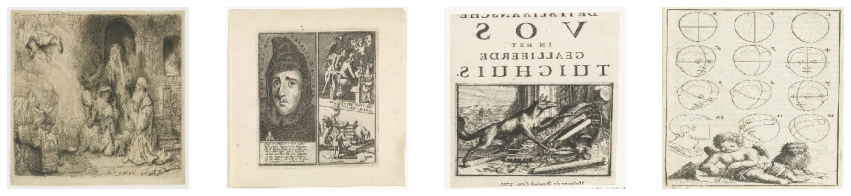

In [136]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))

for i in range(4):

    # convert to unsigned integers for plotting
    image = next(train_generator)[0][0]
    # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
    image = np.squeeze(image) * 0.5 + 0.5
    # plot raw pixel data
    ax[i].imshow(image)
    ax[i].axis('off')

In [137]:
def train_model(model, steps_per_epoch=150, epochs=5, validation_steps=70, workers=7, checkpoint_loc=""):
    """
    Trains a given model

    :steps_per_epoch: Amount of batches uploaded per epoch. Cant be higher than +- 200
    :epochs: Amount of times the model trains on the data
    :validation_steps: Amount of batches used for validation. Cant be higher than +- 50
    :workers: Amount of processes used to load the data
    :checkpoint_loc: Place for the model checkpoints to be saved
    :return: The trained model and some training data
    """ 
    # Create a callback that saves the model's weights
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
#                                                      save_weights_only=True,
#                                                      verbose=1)
    cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc,
                                                     monitor='val_accuracy',
                                                     save_weights_only=True,
                                                     save_best_only=True)
#     cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_loc, 
#                                                      monitor='acc', 
#                                                      save_weights_only=True, 
#                                                      save_best_only=True, 
#                                                      mode='max')

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    begin_time = datetime.datetime.now()
    history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps=validation_steps, workers=workers, callbacks=[cp_callback, early_stopping])
    print(datetime.datetime.now() - begin_time)
    return (model, history)

In [138]:
def plot_history(history):
    #Plots the training data.
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show() 

# Xception model:

In [139]:
def make_model(n_labels):
    base_model = tf.keras.applications.Xception(input_shape = IMG_SHAPE, 
                                                   weights = 'imagenet', 
                                                   include_top=False)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
#     x = BatchNormalization()(x)
    pred = Dense(n_labels, activation='softmax')(x)
    model = Model(base_model.input, pred)
    
    for layer in model.layers[:126]:
        layer.trainable = False
    for layer in model.layers[126:]:
        layer.trainable = True
        
    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1), 
                  metrics=['accuracy'])
    
    return model

model = make_model(n_labels)
# model.summary()

In [141]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n  // validation_generator.batch_size

model, history = train_model(model, steps_per_epoch=STEP_SIZE_TRAIN, epochs=20, validation_steps=STEP_SIZE_VALID, checkpoint_loc="../Model_weights/Xception_single_1100/")


Epoch 1/20
22/22 [==============================] - 20s 749ms/step - loss: 0.9945 - accuracy: 0.7420 - val_loss: 0.8540 - val_accuracy: 0.8229
Epoch 2/20
22/22 [==============================] - 15s 621ms/step - loss: 0.6461 - accuracy: 0.9226 - val_loss: 0.7631 - val_accuracy: 0.8672
Epoch 3/20
22/22 [==============================] - 16s 641ms/step - loss: 0.5448 - accuracy: 0.9721 - val_loss: 0.7441 - val_accuracy: 0.8685
Epoch 4/20
22/22 [==============================] - 17s 678ms/step - loss: 0.4996 - accuracy: 0.9903 - val_loss: 0.6473 - val_accuracy: 0.9284
Epoch 5/20
22/22 [==============================] - 15s 613ms/step - loss: 0.4719 - accuracy: 0.9968 - val_loss: 0.6647 - val_accuracy: 0.9089
Epoch 6/20
22/22 [==============================] - 15s 606ms/step - loss: 0.4592 - accuracy: 0.9993 - val_loss: 0.6523 - val_accuracy: 0.9193
Epoch 7/20
22/22 [==============================] - 15s 631ms/step - loss: 0.4512 - accuracy: 0.9989 - val_loss: 0.6445 - val_accuracy: 0.9232

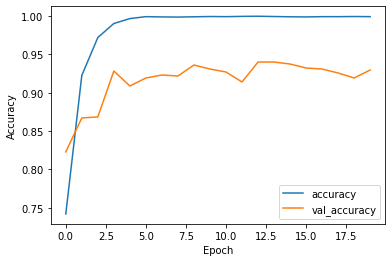

In [142]:
plot_history(history)

In [143]:
# print(STEP_SIZE_TRAIN, STEP_SIZE_VALID)

In [144]:
# Save model
model.save("models/_Xception_single_1100")

# Load model
# model = tf.keras.models.load_model('./models/_Xception_single_100')
# model.load_weights('../Model_weights/Xception_single_100/')


INFO:tensorflow:Assets written to: models/_Xception_single_1100\assets


# Predict the test set
We also have to predict the real test set

In [145]:
def predict_test(model, labels):
    preds = model.predict(test_generator)
    preds_cls_idx = preds.argmax(axis=-1)
    idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
    preds_cls = np.vectorize(idx_to_cls.get)(preds_cls_idx)
    filenames_to_cls = list(zip(test_generator.filenames, preds_cls))
    
    l = []
    n = []
    t = []
    for p in filenames_to_cls:
        n.append(p[0].split("\\")[-1][:-4])
        l.append(p[1])
        t.append(labels[labels['Identifier'] == p[0].split("\\")[-1][:-4]]['Creator'].values[0])
    return pd.DataFrame(list(zip(n, l, t)), columns=['img_name', 'predicted label', 'true label'])

res = predict_test(model, labels)

In [146]:
# res

In [147]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(res['true label'], res['predicted label'])
accuracy

0.9213349225268176

In [22]:
res[['predicted label', 'true label']]

,predicted label,true label
0,"Beham, Hans Sebald","Aldegrever, Heinrich"
1,"Aldegrever, Heinrich","Aldegrever, Heinrich"
2,"Aldegrever, Heinrich","Aldegrever, Heinrich"
3,"Beham, Hans Sebald","Aldegrever, Heinrich"
4,"Galle, Philips","Aldegrever, Heinrich"
...,...,...
10618,Woodbury & Page,Woodbury & Page
10619,Woodbury & Page,Woodbury & Page
10620,Woodbury & Page,Woodbury & Page
10621,Woodbury & Page,Woodbury & Page


In [23]:
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [24]:
# res50 = res.groupby("true label").filter(lambda x: len(x) >= 150)
res50 = res[res['predicted label'] != 'None']
res50 = res50.groupby("true label").filter(lambda x: len(x) >= 150)
restest = res[res['predicted label'] != res['true label']]
restest = restest.groupby("true label").filter(lambda x: len(x) >= 50)
res50

,img_name,predicted label,true label
2070,RP-P-1903-A-24054J,"Callot, Jacques","Callot, Jacques"
2071,RP-P-1904-928,"Callot, Jacques","Callot, Jacques"
2072,RP-P-1909-2815,"Callot, Jacques","Callot, Jacques"
2073,RP-P-1911-3665,"Picart, Bernard","Callot, Jacques"
2074,RP-P-1949-396,"Bolswert, Boëtius Adamsz","Callot, Jacques"
...,...,...,...
9764,SK-A-3066,"Delfos, Abraham",Rembrandt Harmensz. van Rijn
9765,SK-A-3298,"Asser, Eduard Isaac",Rembrandt Harmensz. van Rijn
9766,SK-A-3341,Rembrandt Harmensz. van Rijn,Rembrandt Harmensz. van Rijn
9767,SK-A-3934,Rembrandt Harmensz. van Rijn,Rembrandt Harmensz. van Rijn


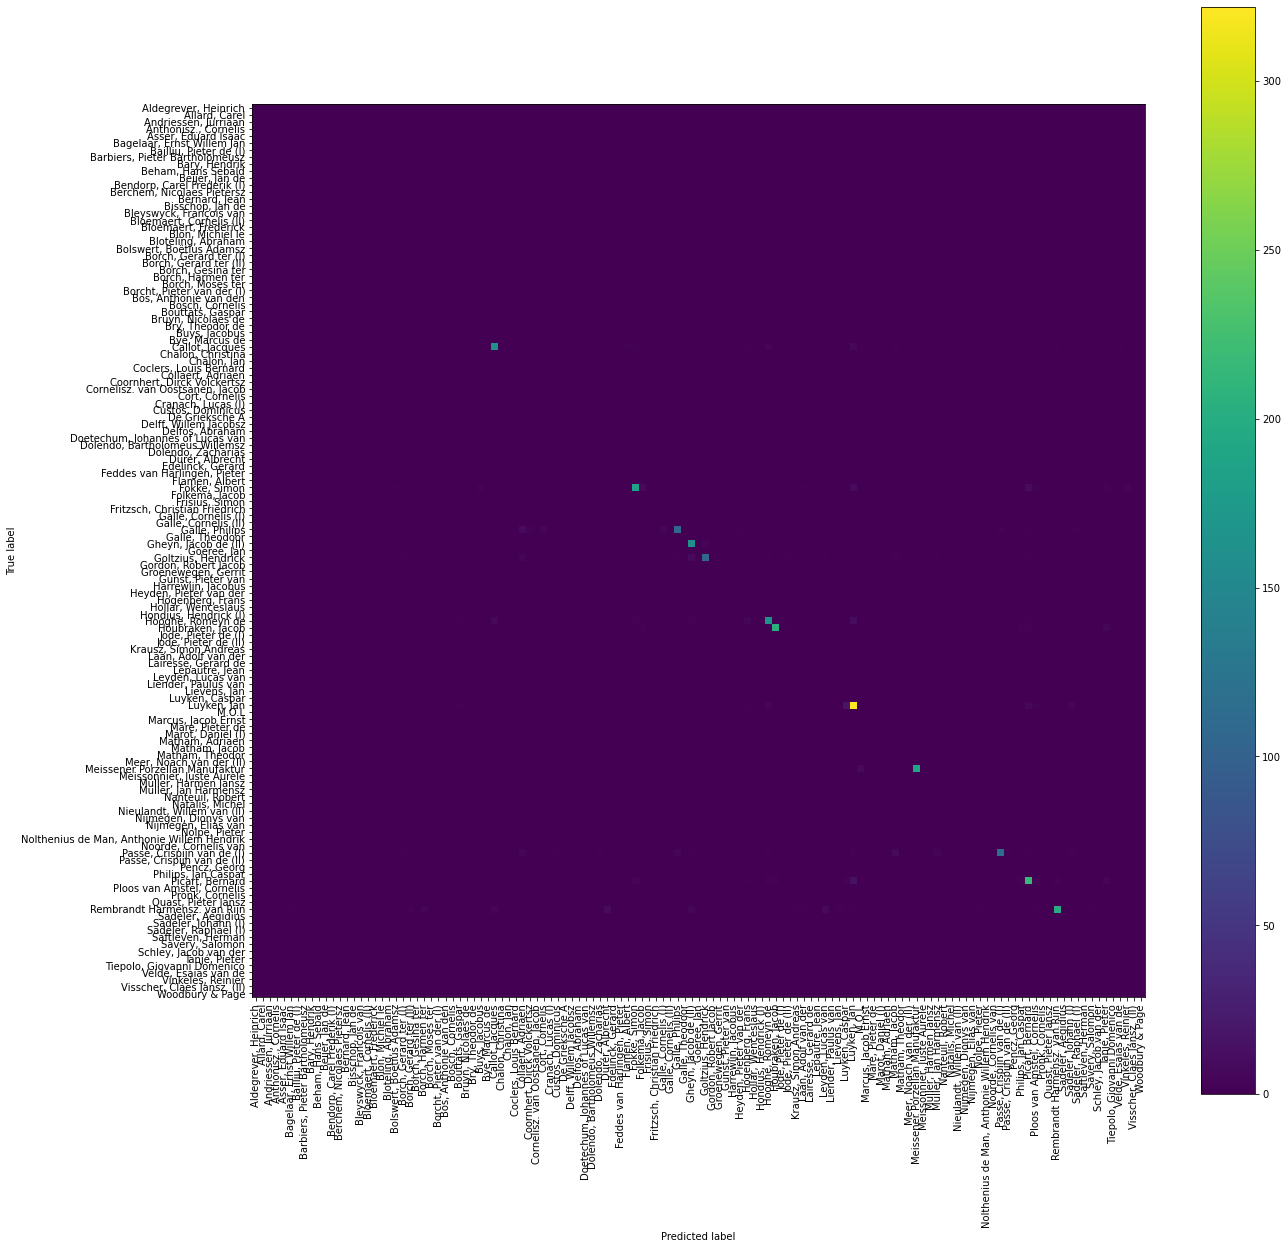

In [25]:
# sns.heatmap(res[['predicted label', 'true label']], annot=True)

fig, ax = plt.subplots(figsize=(20, 20))
ax.tick_params(axis='x', labelrotation=90)

cmd = ConfusionMatrixDisplay.from_predictions(res50['true label'], res50['predicted label'], include_values=False, ax=ax, xticks_rotation='vertical')